In [47]:
# Import dependencies
import pandas as pd
import numpy as np
import datetime as dt
import csv
import os

# Import plotting dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import hvplot.pandas

# Import machine learning dependencies
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import postgres connection dependencies
import psycopg2 as pg
import pandas.io.sql as psql
from sqlalchemy import create_engine
from config import db_password
import sys

import warnings
warnings.filterwarnings("ignore")

# Connect to Database

In [44]:
# Connection resource: https://naysan.ca/2020/05/31/postgresql-to-pandas/
# Connection parameters, yours will be different
param_dic = {
    "host"      : "localhost",
    "database"  : "Crime",
    "user"      : "postgres",
    "password"  : "md5b8f3892f7b5837e4fe7f690982b5c216"
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [45]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

In [46]:
# Connect to the database
conn = connect(param_dic)

column_names = ["Offense_code","OFFENSE_DESCRIPTION","DISTRICT","REPORTING_AREA","SHOOTING","OCCURRED_ON_DATE",
               "YEAR","MONTH","DAY_OF_WEEK","HOUR","STREET","Location"]

# Execute te "SELECT *" query
df = postgresql_to_dataframe(conn, "SELECT * from crime_data", column_names)
df.head()

Connecting to the PostgreSQL database...


NameError: name 'psycopg2' is not defined

# Preprocess the Data

In [38]:
# Import our Boston_Crime.csv
Boston_df = pd.read_csv("Boston_Crime.csv", encoding = "ISO-8859-1", index_col=[0])
Boston_df.head(10)

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
INCIDENT_NUMBER,,,,,,,,,,,,,,,,
PLTEST005,520,NaN,BURGLARY - RESIDENTIAL,B2,289,1,2021-10-13 00:00:00,2021,10,Wednesday,0,NaN,SCHROEDER PLZ,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
PLTEST003,3114,NaN,INVESTIGATE PROPERTY,B2,289,0,2021-05-12 00:00:00,2021,5,Wednesday,0,NaN,SCHROEDER PLZ,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
PLTEST002,3114,NaN,INVESTIGATE PROPERTY,B2,289,0,2021-05-12 00:00:00,2021,5,Wednesday,0,NaN,SCHROEDER PLZ,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
PLTEST001,3114,NaN,INVESTIGATE PROPERTY,B2,,0,2021-03-29 00:00:00,2021,3,Monday,0,NaN,SCHROEDER PLAZA,0.000000,0.000000,"(0, 0)"
312030979,3201,NaN,PROPERTY - LOST/ MISSING,E13,465,0,2021-03-22 00:00:00,2021,3,Monday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
292152228,3301,NaN,VERBAL DISPUTE,C11,347,0,2021-07-28 20:45:00,2021,7,Wednesday,20,NaN,LYON ST,42.306383,-71.060212,"(42.30638322801941, -71.06021217719662)"
282080177,3801,NaN,M/V ACCIDENT - OTHER,A1,,0,2021-11-02 13:23:00,2021,11,Tuesday,13,NaN,CAMBRIDGE ST & BOWDOIN ST\nBOSTON MA 02114\nU...,42.361190,-71.062880,"(42.361189964341946, -71.06287997127626)"
222000453,617,NaN,LARCENY THEFT FROM BUILDING,E13,,0,2021-12-30 12:30:00,2021,12,Thursday,12,NaN,MONTEBELLO RD,42.311768,-71.099716,"(42.31176765436927, -71.09971563708591)"
222000599,1106,NaN,FRAUD - CREDIT CARD / ATM FRAUD,B2,282,0,2021-12-29 22:40:00,2021,12,Wednesday,22,NaN,WASHINGTON ST,42.328663,-71.085634,"(42.32866283555608, -71.08563401183545)"


In [9]:
# Identify the columns that have null values
for column in Boston_df.columns:
    print(f"{column} has {Boston_df[column].isnull().sum()} null values")

INCIDENT_NUMBER has 0 null values
OFFENSE_CODE has 0 null values
OFFENSE_CODE_GROUP has 71721 null values
OFFENSE_DESCRIPTION has 0 null values
DISTRICT has 993 null values
REPORTING_AREA has 0 null values
SHOOTING has 0 null values
OCCURRED_ON_DATE has 0 null values
YEAR has 0 null values
MONTH has 0 null values
DAY_OF_WEEK has 0 null values
HOUR has 0 null values
UCR_PART has 71721 null values
STREET has 679 null values
Lat has 0 null values
Long has 0 null values
Location has 0 null values


In [10]:
# Find duplicate entries
print(f"Duplicate entries: {Boston_df.duplicated().sum()}")

Duplicate entries: 0


In [11]:
# Look at data types and columns
Boston_df.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP     float64
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                 int64
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
UCR_PART               float64
STREET                  object
Lat                    float64
Long                   float64
Location                object
dtype: object

In [12]:
# Drop OFFENSE_CODE_GROUP and UCR_PART columns : have null values throughout
# Also determined to not need these columns - object data types
Crime_df = Boston_df.drop(columns=["OFFENSE_CODE_GROUP", "UCR_PART",
                                   "INCIDENT_NUMBER","REPORTING_AREA","YEAR","STREET"])


# View new DataFrame
Crime_df.head()

,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,SHOOTING,OCCURRED_ON_DATE,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,Location
0,520,BURGLARY - RESIDENTIAL,B2,1,2021-10-13 00:00:00,10,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
1,3114,INVESTIGATE PROPERTY,B2,0,2021-05-12 00:00:00,5,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
2,3114,INVESTIGATE PROPERTY,B2,0,2021-05-12 00:00:00,5,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
3,3114,INVESTIGATE PROPERTY,B2,0,2021-03-29 00:00:00,3,Monday,0,0.000000,0.000000,"(0, 0)"
4,3201,PROPERTY - LOST/ MISSING,E13,0,2021-03-22 00:00:00,3,Monday,0,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"


In [13]:
# Rename columns for easier identification (aka not all caps!)
Crime_df = Crime_df.rename(columns={
    "OFFENSE_CODE": "Offense_Code",
    "OFFENSE_DESCRIPTION": "Offense_Info",
    "DISTRICT": "District",
    "SHOOTING": "Shooting",
    "OCCURRED_ON_DATE": "Date",
    "MONTH": "Month",
    "DAY_OF_WEEK": "Day",
    "HOUR": "Hour",
    "Lat":"Lat",
    "Long":"Long",
    "LOCATION": "Location",
})

# Display the DataFrame
Crime_df.head()

,Offense_Code,Offense_Info,District,Shooting,Date,Month,Day,Hour,Lat,Long,Location
0,520,BURGLARY - RESIDENTIAL,B2,1,2021-10-13 00:00:00,10,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
1,3114,INVESTIGATE PROPERTY,B2,0,2021-05-12 00:00:00,5,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
2,3114,INVESTIGATE PROPERTY,B2,0,2021-05-12 00:00:00,5,Wednesday,0,42.333679,-71.091878,"(42.33367921810846, -71.09187754618458)"
3,3114,INVESTIGATE PROPERTY,B2,0,2021-03-29 00:00:00,3,Monday,0,0.000000,0.000000,"(0, 0)"
4,3201,PROPERTY - LOST/ MISSING,E13,0,2021-03-22 00:00:00,3,Monday,0,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"


In [14]:
Crime_df["District"].value_counts()
Crime_df['District'] = Crime_df['District'].fillna("Unknown")
Crime_df.isnull().sum()

Offense_Code    0
Offense_Info    0
District        0
Shooting        0
Date            0
Month           0
Day             0
Hour            0
Lat             0
Long            0
Location        0
dtype: int64

In [15]:
# Print out Offense_Info value counts
offense_counts = Crime_df.Offense_Info.value_counts()
offense_counts

INVESTIGATE PERSON                            6841
SICK ASSIST                                   4969
M/V - LEAVING SCENE - PROPERTY DAMAGE         4678
INVESTIGATE PROPERTY                          3531
VANDALISM                                     3287
                                              ... 
CHILD REQUIRING ASSISTANCE (FOMERLY CHINS)       1
Justifiable Homicide                             1
TRUANCY / RUNAWAY                                1
CONSPIRACY EXCEPT DRUG LAW                       1
MANSLAUGHTER - NEGLIGENCE                        1
Name: Offense_Info, Length: 121, dtype: int64

<AxesSubplot:ylabel='Density'>

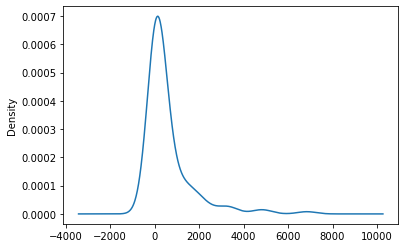

In [16]:
# Plot density 
offense_counts.plot.density()

In [17]:
# Determine which values to replace
replace_offense = list(offense_counts[offense_counts < 1200].index)

# Replace in DataFrame
for offense in replace_offense:
    Crime_df.Offense_Info = Crime_df.Offense_Info.replace(offense, "Other")
    
# Check to make sure binning was successful
Crime_df.Offense_Info.value_counts()

Other                                           21443
INVESTIGATE PERSON                               6841
SICK ASSIST                                      4969
M/V - LEAVING SCENE - PROPERTY DAMAGE            4678
INVESTIGATE PROPERTY                             3531
VANDALISM                                        3287
TOWED MOTOR VEHICLE                              3215
ASSAULT - SIMPLE                                 2795
LARCENY SHOPLIFTING                              2316
M/V ACCIDENT - PROPERTY DAMAGE                   2095
LARCENY THEFT FROM MV - NON-ACCESSORY            2065
SICK/INJURED/MEDICAL - PERSON                    2010
PROPERTY - LOST/ MISSING                         1811
VERBAL DISPUTE                                   1711
THREATS TO DO BODILY HARM                        1640
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE     1568
LARCENY THEFT FROM BUILDING                      1551
ASSAULT - AGGRAVATED                             1546
LARCENY ALL OTHERS          

In [18]:
# Improve the Crime DataFrame
Crime_df = Crime_df.drop(columns=["Offense_Code","Shooting", "Date", "Location", "Lat","Long"])

In [19]:
# Encode Day
Crime_Day = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday" :7
}

# # Encode District (for different clustering effect)
# Crime_District = {
#     "Unknown": 0,
#     "A1": 1,
#     "A7": 2,
#     "A15": 3,
#     "B2": 4,
#     "B3": 5,
#     "C6": 6,
#     "C11": 7,
#     "D4": 8,
#     "D14": 9,
#     "E5": 10,
#     "E13": 11,
#     "E18": 12,
#     "External" :13
# }
    

Crime_df["Crime_Day"] = Crime_df["Day"].apply(lambda x: Crime_Day[x])
# Crime_df["Crime_District"] = Crime_df["District"].apply(lambda x: Crime_District[x])

In [20]:
# Check the data types
Crime_df.dtypes

Offense_Info    object
District        object
Month            int64
Day             object
Hour             int64
Crime_Day        int64
dtype: object

In [21]:
Crime_df.head()

,Offense_Info,District,Month,Day,Hour,Crime_Day
0,Other,B2,10,Wednesday,0,3
1,INVESTIGATE PROPERTY,B2,5,Wednesday,0,3
2,INVESTIGATE PROPERTY,B2,5,Wednesday,0,3
3,INVESTIGATE PROPERTY,B2,3,Monday,0,1
4,PROPERTY - LOST/ MISSING,E13,3,Monday,0,1


In [22]:
# Use get_dummies() to create variables for text features.
X = pd.get_dummies(Crime_df, columns=["Offense_Info","District"]).drop(columns=["Day"])
X.head(10)

,Month,Hour,Crime_Day,Offense_Info_ASSAULT - AGGRAVATED,Offense_Info_ASSAULT - SIMPLE,Offense_Info_DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE,Offense_Info_INVESTIGATE PERSON,Offense_Info_INVESTIGATE PROPERTY,Offense_Info_LARCENY ALL OTHERS,Offense_Info_LARCENY SHOPLIFTING,...,District_B3,District_C11,District_C6,District_D14,District_D4,District_E13,District_E18,District_E5,District_External,District_Unknown
0,10,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,7,20,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,11,13,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,12,12,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,12,22,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,11,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Apply PCA to reduce the amount of features
Note: Determined the number of PCA components by using number of Districts.

In [23]:
# Standardize the data with StandardScaler()
X_train_scaled = StandardScaler().fit_transform(X)
print(X_train_scaled[0:1])

# Using PCA to reduce dimension to 33 principal components.
# N components is 95%, which comprises about 95% of the data.
pca = PCA(n_components=0.95)
Crime_pca = pca.fit_transform(X_train_scaled)
Crime_pca

[[ 0.99153873 -2.01104693 -0.48758077 -0.14842721 -0.20137213 -0.149503
  -0.32471651 -0.22755612 -0.13750977 -0.18267281 -0.14867233 -0.17217923
  -0.26415169 -0.13682395 -0.17346278  1.53125043 -0.16094948 -0.27283643
  -0.16980379 -0.15297546 -0.21663378 -0.21916131 -0.15633095 -0.35644176
  -0.14125232 -0.21835651  2.49467153 -0.33974914 -0.38166251 -0.30269988
  -0.27304286 -0.38467756 -0.23659764 -0.24287381 -0.22052049 -0.04454012
  -0.11848925]]


array([[ 2.0228991 , -1.25787514,  0.25987128, ...,  0.2736874 ,
         0.40431396,  0.8606424 ],
       [-0.22282608, -1.19123878, -0.13666088, ..., -0.46900901,
        -0.30993699,  0.63614207],
       [-0.22282608, -1.19123878, -0.13666088, ..., -0.46900901,
        -0.30993699,  0.63614207],
       ...,
       [-0.48826091,  0.28345808, -0.90025535, ...,  0.15315321,
        -0.01193159, -0.08912161],
       [ 2.10342218,  1.30708549, -1.17407312, ..., -0.30403527,
         0.14581049, -0.78195971],
       [-1.22956781, -0.2892128 ,  1.66102678, ..., -1.69751448,
        -0.85121054,  1.63614345]])

In [24]:
# Fetch the explained variance
pca.explained_variance_ratio_

array([0.03604134, 0.03525591, 0.03317444, 0.03205151, 0.03175797,
       0.03153306, 0.0308278 , 0.03037821, 0.03003832, 0.02949766,
       0.02936531, 0.0288442 , 0.02876029, 0.02859164, 0.02849138,
       0.0283164 , 0.02816261, 0.02800338, 0.02792775, 0.02781459,
       0.02778176, 0.02767904, 0.02760829, 0.02745052, 0.02733691,
       0.02729476, 0.02708896, 0.0269879 , 0.02667777, 0.02634722,
       0.02578535, 0.02499222, 0.02495842])

In [25]:
# Create a DataFrame with the nine principal components.
# To create a more involved representation, it determined there are 33 different components
pcs_df = pd.DataFrame(
    data = Crime_pca, columns=["PC 1", "PC 2", "PC 3","PC 4","PC 5","PC 6",
                                "PC 7", "PC 8", "PC 9", "PC 10", "PC 11", "PC 12", "PC 13",
                                "PC 14", "PC 15", "PC 16", "PC 17","PC 18","PC 19","PC 20",
                                "PC 21", "PC 22", "PC 23", "PC 24", "PC 25", "PC 26", "PC 27",
                                "PC 28", "PC 29", "PC 30", "PC 31", "PC 32", "PC 33"])

# # Print the shape of the clustered_df
# print(pcs_df.shape)

# Now print the actual data
pcs_df.head(20)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33
0,2.022899,-1.257875,0.259871,-0.062611,-0.491202,2.119186,0.577067,-0.174775,-0.446545,0.206110,...,-0.332838,0.247276,-0.289629,0.497476,-0.288936,-0.285452,0.710252,0.273687,0.404314,0.860642
1,-0.222826,-1.191239,-0.136661,-0.323937,-1.071726,2.321842,-0.183857,-0.301613,1.823406,0.597940,...,-0.821101,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142
2,-0.222826,-1.191239,-0.136661,-0.323937,-1.071726,2.321842,-0.183857,-0.301613,1.823406,0.597940,...,-0.821101,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142
3,-0.081238,-1.212845,-0.253297,-0.242124,-1.024273,2.065813,-0.234928,0.063341,2.049139,0.435742,...,-0.833314,0.007163,0.091928,0.525373,0.394954,-0.616534,-0.180486,-0.144137,-0.629149,0.530961
4,-0.278359,0.272634,0.180509,-1.220769,-0.032302,-0.747283,0.685549,0.663247,1.184251,-0.479803,...,-0.528203,-0.986824,-0.384400,-1.669633,-0.865322,-2.203614,-1.305564,0.635602,-0.726078,0.792742
5,-1.085337,-1.274550,-0.789211,1.574789,-1.218454,-1.026373,-1.332581,-0.313352,-0.072342,-0.576687,...,-1.249182,0.413039,-1.548097,0.448696,1.542903,1.433182,-1.339937,-0.260106,-0.339612,0.820485
6,-0.569429,0.786302,0.624863,-1.342668,-1.286901,-0.941017,-0.042525,-0.551566,-0.993892,1.840996,...,-2.300415,3.572340,-1.508451,-0.181356,1.651135,-2.188432,1.642356,0.840888,-0.316155,1.001427
7,-0.768165,0.758771,0.097077,-0.758932,0.689114,-0.247721,1.775212,0.092693,-0.488270,-2.489347,...,-1.925779,-0.983076,-1.722443,0.590413,-2.970538,1.580323,-0.140971,1.481468,-0.461470,-0.283353
8,1.782880,-1.075939,-0.799816,0.270739,-0.811458,1.717721,0.635866,0.554425,-1.210906,-0.045150,...,-0.088539,0.336522,0.085716,0.083638,0.159381,-0.734927,-0.082360,0.102105,-0.461253,-0.159900
9,2.009392,0.727511,1.208480,-1.654088,-1.055342,-0.037257,0.122452,-1.203737,-0.921496,0.515788,...,-0.299839,0.195639,-0.327838,-0.116521,-0.695500,-0.060052,0.513023,1.126145,0.164325,1.419446


# Use Elbow Curve to find optimal clusters

In [26]:
inertia = []
k = list(range(1,40))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)
    
# Create an elbow curve to find the best value for K.
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [27]:
# Initialize the K-Means model.
model = KMeans(n_clusters=34, random_state=0)
    
# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create return DataFrame with predicted clusters
pcs_df["Class"]=model.labels_
pcs_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,Class
0,2.022899,-1.257875,0.259871,-0.062611,-0.491202,2.119186,0.577067,-0.174775,-0.446545,0.206110,...,0.247276,-0.289629,0.497476,-0.288936,-0.285452,0.710252,0.273687,0.404314,0.860642,4
1,-0.222826,-1.191239,-0.136661,-0.323937,-1.071726,2.321842,-0.183857,-0.301613,1.823406,0.597940,...,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142,29
2,-0.222826,-1.191239,-0.136661,-0.323937,-1.071726,2.321842,-0.183857,-0.301613,1.823406,0.597940,...,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142,29
3,-0.081238,-1.212845,-0.253297,-0.242124,-1.024273,2.065813,-0.234928,0.063341,2.049139,0.435742,...,0.007163,0.091928,0.525373,0.394954,-0.616534,-0.180486,-0.144137,-0.629149,0.530961,29
4,-0.278359,0.272634,0.180509,-1.220769,-0.032302,-0.747283,0.685549,0.663247,1.184251,-0.479803,...,-0.986824,-0.384400,-1.669633,-0.865322,-2.203614,-1.305564,0.635602,-0.726078,0.792742,16


In [28]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.
clustered_df = pd.concat([Crime_df, pcs_df], axis=1)

# Print the shape of the clustered_df
print(clustered_df.shape)

(71721, 40)


In [29]:
# Print dataframe
clustered_df.head(10)

,Offense_Info,District,Month,Day,Hour,Crime_Day,PC 1,PC 2,PC 3,PC 4,...,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,Class
0,Other,B2,10,Wednesday,0,3,2.022899,-1.257875,0.259871,-0.062611,...,0.247276,-0.289629,0.497476,-0.288936,-0.285452,0.710252,0.273687,0.404314,0.860642,4
1,INVESTIGATE PROPERTY,B2,5,Wednesday,0,3,-0.222826,-1.191239,-0.136661,-0.323937,...,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142,29
2,INVESTIGATE PROPERTY,B2,5,Wednesday,0,3,-0.222826,-1.191239,-0.136661,-0.323937,...,-0.162515,0.061061,0.272580,0.431456,-0.243762,-0.136779,-0.469009,-0.309937,0.636142,29
3,INVESTIGATE PROPERTY,B2,3,Monday,0,1,-0.081238,-1.212845,-0.253297,-0.242124,...,0.007163,0.091928,0.525373,0.394954,-0.616534,-0.180486,-0.144137,-0.629149,0.530961,29
4,PROPERTY - LOST/ MISSING,E13,3,Monday,0,1,-0.278359,0.272634,0.180509,-1.220769,...,-0.986824,-0.384400,-1.669633,-0.865322,-2.203614,-1.305564,0.635602,-0.726078,0.792742,16
5,VERBAL DISPUTE,C11,7,Wednesday,20,3,-1.085337,-1.274550,-0.789211,1.574789,...,0.413039,-1.548097,0.448696,1.542903,1.433182,-1.339937,-0.260106,-0.339612,0.820485,1
6,M/V ACCIDENT - OTHER,A1,11,Tuesday,13,2,-0.569429,0.786302,0.624863,-1.342668,...,3.572340,-1.508451,-0.181356,1.651135,-2.188432,1.642356,0.840888,-0.316155,1.001427,18
7,LARCENY THEFT FROM BUILDING,E13,12,Thursday,12,4,-0.768165,0.758771,0.097077,-0.758932,...,-0.983076,-1.722443,0.590413,-2.970538,1.580323,-0.140971,1.481468,-0.461470,-0.283353,21
8,Other,B2,12,Wednesday,22,3,1.782880,-1.075939,-0.799816,0.270739,...,0.336522,0.085716,0.083638,0.159381,-0.734927,-0.082360,0.102105,-0.461253,-0.159900,4
9,Other,A1,11,Tuesday,0,2,2.009392,0.727511,1.208480,-1.654088,...,0.195639,-0.327838,-0.116521,-0.695500,-0.060052,0.513023,1.126145,0.164325,1.419446,0


In [30]:
clustered_df.describe()

,Month,Hour,Crime_Day,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,...,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,Class
count,71721.000000,71721.000000,71721.000000,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,...,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,7.172100e+04,71721.000000
mean,6.689700,12.802415,3.962006,-7.619504e-16,4.950423e-18,6.847312e-17,2.607997e-16,-2.959728e-17,9.715941e-16,4.456310e-17,...,-1.548439e-17,-2.906640e-16,-4.527942e-17,-2.183742e-17,-1.056462e-16,-3.428455e-16,2.786262e-16,-6.238153e-16,-1.612888e-15,16.107123
std,3.338571,6.366089,1.973032,1.154793e+00,1.142141e+00,1.107913e+00,1.089001e+00,1.084002e+00,1.080157e+00,1.068010e+00,...,1.005723e+00,1.004948e+00,1.001152e+00,9.992828e-01,9.935246e-01,9.873503e-01,9.767658e-01,9.616262e-01,9.609757e-01,10.341605
min,1.000000,0.000000,1.000000,-1.726490e+00,-1.804674e+00,-2.385363e+00,-2.623426e+00,-2.553006e+00,-3.295666e+00,-3.054200e+00,...,-4.314216e+00,-4.315272e+00,-4.004685e+00,-4.856761e+00,-3.217302e+00,-5.159982e+00,-3.454442e+00,-5.696173e+00,-4.026850e+00,0.000000
25%,4.000000,9.000000,2.000000,-8.819097e-01,-8.553470e-01,-7.747956e-01,-8.004583e-01,-7.595639e-01,-7.518096e-01,-5.751918e-01,...,-5.109517e-01,-4.375639e-01,-5.578328e-01,-4.011627e-01,-5.081931e-01,-4.611317e-01,-6.651423e-01,-5.424282e-01,-6.046731e-01,7.000000
50%,7.000000,14.000000,4.000000,-5.032674e-01,-3.359059e-01,-1.737973e-01,1.072323e-02,1.340462e-01,-6.982716e-02,2.810203e-03,...,-8.313584e-02,-1.599009e-02,-1.738285e-02,-9.990408e-03,-2.157041e-02,4.240291e-02,-3.977534e-02,-2.484445e-02,6.829390e-04,16.000000
75%,10.000000,18.000000,6.000000,1.373894e+00,7.557831e-01,5.645329e-01,7.970581e-01,7.547265e-01,5.779226e-01,6.523213e-01,...,3.217238e-01,3.649851e-01,4.693815e-01,3.950390e-01,4.648563e-01,5.076015e-01,6.196094e-01,5.003305e-01,6.006833e-01,25.000000
max,12.000000,23.000000,7.000000,3.806287e+00,4.381401e+00,4.654360e+00,2.945127e+00,2.727796e+00,3.468064e+00,3.499641e+00,...,6.884931e+00,1.007494e+01,7.329424e+00,9.434624e+00,1.372802e+01,6.484442e+00,6.879139e+00,5.859451e+00,5.234174e+00,33.000000


In [39]:
# Save clustered_df to CSV
clustered_df.to_csv("Clustered_df.csv", index=False)

# End of first part of cluster model. Please see part 2 called "ML_Clustering_CrimeAndDistrict_Part2.ipynb"